In [185]:
import pandas as pd
from pyspark.sql import functions as F
from pyspark.ml.feature import PCA
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

# Descritivas

In [198]:
data = pd.read_csv('credit_aproval.txt')

In [230]:
data_ = spark.read.csv('credit_aproval.txt', header=True)

In [231]:
data_.show()

+---+-----+------+---+---+---+---+-----+---+---+---+---+---+-----+-----+-----+
| A1|   A2|    A3| A4| A5| A6| A7|   A8| A9|A10|A11|A12|A13|  A14|  A15|class|
+---+-----+------+---+---+---+---+-----+---+---+---+---+---+-----+-----+-----+
|  b|30.83|     0|  u|  g|  w|  v| 1.25|  t|  t| 01|  f|  g|00202|    0|    +|
|  a|58.67|  4.46|  u|  g|  q|  h| 3.04|  t|  t| 06|  f|  g|00043|  560|    +|
|  a|24.50|   0.5|  u|  g|  q|  h|  1.5|  t|  f|  0|  f|  g|00280|  824|    +|
|  b|27.83|  1.54|  u|  g|  w|  v| 3.75|  t|  t| 05|  t|  g|00100|    3|    +|
|  b|20.17| 5.625|  u|  g|  w|  v| 1.71|  t|  f|  0|  f|  s|00120|    0|    +|
|  b|32.08|     4|  u|  g|  m|  v|  2.5|  t|  f|  0|  t|  g|00360|    0|    +|
|  b|33.17|  1.04|  u|  g|  r|  h|  6.5|  t|  f|  0|  t|  g|00164|31285|    +|
|  a|22.92|11.585|  u|  g| cc|  v| 0.04|  t|  f|  0|  f|  g|00080| 1349|    +|
|  b|54.42|   0.5|  y|  p|  k|  h| 3.96|  t|  f|  0|  f|  g|00180|  314|    +|
|  b|42.50| 4.915|  y|  p|  w|  v|3.165|  t|  f|  0|

#### Descritiva simples para atributos continuos

In [22]:
data_.select(['A2']).describe().show()

+-------+-----------------+
|summary|               A2|
+-------+-----------------+
|  count|              678|
|   mean|31.56817109144546|
| stddev|11.95786249827088|
|    min|            13.75|
|    max|            80.25|
+-------+-----------------+



In [21]:
data_.select(['A2']).summary().show()

+-------+-----------------+
|summary|               A2|
+-------+-----------------+
|  count|              678|
|   mean|31.56817109144546|
| stddev|11.95786249827088|
|    min|            13.75|
|    25%|            22.58|
|    50%|            28.42|
|    75%|            38.25|
|    max|            80.25|
+-------+-----------------+



In [46]:
# Variancia
data_.agg(F.variance('A2')).show()

+-----------------+
|     var_samp(A2)|
+-----------------+
|142.9904755275531|
+-----------------+



#### Descritiva simples para atributos categóricos

In [48]:
data_.groupby('A1').count().show()

+----+-----+
|  A1|count|
+----+-----+
|null|   12|
|   b|  468|
|   a|  210|
+----+-----+



#### Analise de nulos

In [51]:
data_.filter(data_['A2'].isNull()).count()

12

In [52]:
data_.filter(data_['A2'].isNotNull()).count()

678

#### Duplicados

In [154]:
# Todos os registros do dataset
print data_.count()
# Todos os registros únicos do dataset
print data_.distinct().count()
# Todos os registros únicos do dataset, 
# levando em consideração os atributos: 'A1', 'A2' e 'A5' 
print data_.select(['A1', 'A2', 'A5']).distinct().count()

690
690
529


#### Filtros

In [56]:
data_.filter(data_['A2'] > 11).limit(5).show()

+---+-----+-----+---+---+---+---+----+---+---+---+---+---+-----+---+-----+
| A1|   A2|   A3| A4| A5| A6| A7|  A8| A9|A10|A11|A12|A13|  A14|A15|class|
+---+-----+-----+---+---+---+---+----+---+---+---+---+---+-----+---+-----+
|  b|30.83|    0|  u|  g|  w|  v|1.25|  t|  t| 01|  f|  g|00202|  0|    +|
|  a|58.67| 4.46|  u|  g|  q|  h|3.04|  t|  t| 06|  f|  g|00043|560|    +|
|  a|24.50|  0.5|  u|  g|  q|  h| 1.5|  t|  f|  0|  f|  g|00280|824|    +|
|  b|27.83| 1.54|  u|  g|  w|  v|3.75|  t|  t| 05|  t|  g|00100|  3|    +|
|  b|20.17|5.625|  u|  g|  w|  v|1.71|  t|  f|  0|  f|  s|00120|  0|    +|
+---+-----+-----+---+---+---+---+----+---+---+---+---+---+-----+---+-----+



In [57]:
data_.select(['A1', 'A2', 'A3', 'class']).filter(data_['A2'] > 11).limit(5).show()

+---+-----+-----+-----+
| A1|   A2|   A3|class|
+---+-----+-----+-----+
|  b|30.83|    0|    +|
|  a|58.67| 4.46|    +|
|  a|24.50|  0.5|    +|
|  b|27.83| 1.54|    +|
|  b|20.17|5.625|    +|
+---+-----+-----+-----+



# Preprocessamento

#### Eliminação manual

In [106]:
data_temp = data_.select(['A1', 'A2', 'A3', 'A4', 'A5','class'])\
            .filter((data_['A5']=='g') | (data_['A1']\
            .isNull()))
print "Tamanho do extrato: {}".format(data_temp.count())
data_temp.show()

Tamanho do extrato: 523
+---+-----+------+---+---+-----+
| A1|   A2|    A3| A4| A5|class|
+---+-----+------+---+---+-----+
|  b|30.83|     0|  u|  g|    +|
|  a|58.67|  4.46|  u|  g|    +|
|  a|24.50|   0.5|  u|  g|    +|
|  b|27.83|  1.54|  u|  g|    +|
|  b|20.17| 5.625|  u|  g|    +|
|  b|32.08|     4|  u|  g|    +|
|  b|33.17|  1.04|  u|  g|    +|
|  a|22.92|11.585|  u|  g|    +|
|  b|22.08|  0.83|  u|  g|    +|
|  b|29.92| 1.835|  u|  g|    +|
|  a|38.25|     6|  u|  g|    +|
|  b|48.08|  6.04|  u|  g|    +|
|  a|45.83|  10.5|  u|  g|    +|
|  b|28.25| 0.875|  u|  g|    +|
|  a|23.25| 5.875|  u|  g|    +|
|  b|21.83|  0.25|  u|  g|    +|
|  a|19.17| 8.585|  u|  g|    +|
|  b|25.00| 11.25|  u|  g|    +|
|  b|23.25|     1|  u|  g|    +|
|  a|47.75|     8|  u|  g|    +|
+---+-----+------+---+---+-----+
only showing top 20 rows



In [110]:
print "Quantidade de NAs no extrato: {}"\
    .format(data_temp.filter(data_temp['A1']\
    .isNull()).count())

data_temp.filter(data_temp['A1']\
        .isNull()).show()

Quantidade de NAs no extrato: 12
+----+-----+-----+---+---+-----+
|  A1|   A2|   A3| A4| A5|class|
+----+-----+-----+---+---+-----+
|null|24.50|12.75|  u|  g|    +|
|null|40.83|  3.5|  u|  g|    -|
|null|32.25|  1.5|  u|  g|    -|
|null|28.17|0.585|  u|  g|    -|
|null|29.75|0.665|  u|  g|    -|
|null|26.50| 2.71|  y|  p|    -|
|null|45.33|    1|  u|  g|    -|
|null|20.42|  7.5|  u|  g|    +|
|null|20.08|0.125|  u|  g|    +|
|null|42.25| 1.75|  y|  p|    -|
|null|33.17| 2.25|  y|  p|    -|
|null|29.50|    2|  y|  p|    -|
+----+-----+-----+---+---+-----+



In [111]:
data_temp.dropna('any').count()

503

#### Eliminação manual: excluindo colunas

In [113]:
data_temp.show()

+---+-----+------+---+---+-----+
| A1|   A2|    A3| A4| A5|class|
+---+-----+------+---+---+-----+
|  b|30.83|     0|  u|  g|    +|
|  a|58.67|  4.46|  u|  g|    +|
|  a|24.50|   0.5|  u|  g|    +|
|  b|27.83|  1.54|  u|  g|    +|
|  b|20.17| 5.625|  u|  g|    +|
|  b|32.08|     4|  u|  g|    +|
|  b|33.17|  1.04|  u|  g|    +|
|  a|22.92|11.585|  u|  g|    +|
|  b|22.08|  0.83|  u|  g|    +|
|  b|29.92| 1.835|  u|  g|    +|
|  a|38.25|     6|  u|  g|    +|
|  b|48.08|  6.04|  u|  g|    +|
|  a|45.83|  10.5|  u|  g|    +|
|  b|28.25| 0.875|  u|  g|    +|
|  a|23.25| 5.875|  u|  g|    +|
|  b|21.83|  0.25|  u|  g|    +|
|  a|19.17| 8.585|  u|  g|    +|
|  b|25.00| 11.25|  u|  g|    +|
|  b|23.25|     1|  u|  g|    +|
|  a|47.75|     8|  u|  g|    +|
+---+-----+------+---+---+-----+
only showing top 20 rows



In [119]:
# Retirando as variaveis categóricas
data_temp.drop(F.col('A1'))\
        .drop(F.col('A4'))\
        .drop(F.col('A5')).show()

+-----+------+-----+
|   A2|    A3|class|
+-----+------+-----+
|30.83|     0|    +|
|58.67|  4.46|    +|
|24.50|   0.5|    +|
|27.83|  1.54|    +|
|20.17| 5.625|    +|
|32.08|     4|    +|
|33.17|  1.04|    +|
|22.92|11.585|    +|
|22.08|  0.83|    +|
|29.92| 1.835|    +|
|38.25|     6|    +|
|48.08|  6.04|    +|
|45.83|  10.5|    +|
|28.25| 0.875|    +|
|23.25| 5.875|    +|
|21.83|  0.25|    +|
|19.17| 8.585|    +|
|25.00| 11.25|    +|
|23.25|     1|    +|
|47.75|     8|    +|
+-----+------+-----+
only showing top 20 rows



#### Sampling: Test and Training

In [132]:
train = data_.sample(withReplacement=False, fraction=0.8, seed=27)

In [133]:
print train.count()
train.limit(10).show()

567
+---+-----+------+---+---+---+---+-----+---+---+---+---+---+-----+----+-----+
| A1|   A2|    A3| A4| A5| A6| A7|   A8| A9|A10|A11|A12|A13|  A14| A15|class|
+---+-----+------+---+---+---+---+-----+---+---+---+---+---+-----+----+-----+
|  b|30.83|     0|  u|  g|  w|  v| 1.25|  t|  t| 01|  f|  g|00202|   0|    +|
|  a|24.50|   0.5|  u|  g|  q|  h|  1.5|  t|  f|  0|  f|  g|00280| 824|    +|
|  b|27.83|  1.54|  u|  g|  w|  v| 3.75|  t|  t| 05|  t|  g|00100|   3|    +|
|  b|32.08|     4|  u|  g|  m|  v|  2.5|  t|  f|  0|  t|  g|00360|   0|    +|
|  a|22.92|11.585|  u|  g| cc|  v| 0.04|  t|  f|  0|  f|  g|00080|1349|    +|
|  b|54.42|   0.5|  y|  p|  k|  h| 3.96|  t|  f|  0|  f|  g|00180| 314|    +|
|  b|42.50| 4.915|  y|  p|  w|  v|3.165|  t|  f|  0|  t|  g|00052|1442|    +|
|  b|22.08|  0.83|  u|  g|  c|  h|2.165|  f|  f|  0|  t|  g|00128|   0|    +|
|  a|38.25|     6|  u|  g|  k|  v|    1|  t|  f|  0|  t|  g|00000|   0|    +|
|  b|48.08|  6.04|  u|  g|  k|  v| 0.04|  f|  f|  0|  f|  g|

In [134]:
test = data_.subtract(train)

In [135]:
print test.count()
test.limit(10).show()

123
+---+-----+-----+---+---+---+---+-----+---+---+---+---+---+-----+----+-----+
| A1|   A2|   A3| A4| A5| A6| A7|   A8| A9|A10|A11|A12|A13|  A14| A15|class|
+---+-----+-----+---+---+---+---+-----+---+---+---+---+---+-----+----+-----+
|  b|39.50|1.625|  u|  g|  c|  v|  1.5|  f|  f|  0|  f|  g|00000| 316|    -|
|  b|28.25|5.125|  u|  g|  x|  v| 4.75|  t|  t| 02|  f|  g|00420|   7|    +|
|  a|27.25| 0.29|  u|  g|  m|  h|0.125|  f|  t| 01|  t|  g|00272| 108|    -|
|  b|23.08|    0|  u|  g|  k|  v|    1|  f|  t| 11|  f|  s|00000|   0|    -|
|  b|29.92|1.835|  u|  g|  c|  h|4.335|  t|  f|  0|  f|  g|00260| 200|    +|
|  b|34.08| 0.08|  y|  p|  m| bb| 0.04|  t|  t| 01|  t|  g|00280|2000|    +|
|  b|34.92|    5|  u|  g|  x|  h|  7.5|  t|  t| 06|  t|  g|00000|1000|    +|
|  b|19.17|  9.5|  u|  g|  w|  v|  1.5|  t|  f|  0|  f|  g|00120|2206|    +|
|  a|27.67|  1.5|  u|  g|  m|  v|    2|  t|  f|  0|  f|  s|00368|   0|    -|
|  b|33.17|3.165|  y|  p|  x|  v|3.165|  t|  t| 03|  t|  g|00380|   0|  

#### Balanceamento

In [136]:
data_.groupby('class').count().show()

+-----+-----+
|class|count|
+-----+-----+
|    +|  307|
|    -|  383|
+-----+-----+



In [144]:
data_positive = data_.filter(data_['class'] == '+')\
                .limit(300)

data_negative = data_.filter(data_['class'] == '-')\
                .limit(300)

balanced_data = data_positive.union(data_negative)

In [146]:
balanced_data.groupby('class').count().show()

+-----+-----+
|class|count|
+-----+-----+
|    +|  300|
|    -|  300|
+-----+-----+



#### Data Cleaning

In [148]:
# Deduplicação
print data_.count()

print data_.drop_duplicates(subset=['A1', 'A2', 'A5']).count()

690
529


+--------+-----+------+---+---+---+---+-----+---+---+---+---+---+-----+-----+-----+
|      A1|   A2|    A3| A4| A5| A6| A7|   A8| A9|A10|A11|A12|A13|  A14|  A15|class|
+--------+-----+------+---+---+---+---+-----+---+---+---+---+---+-----+-----+-----+
| class_b|30.83|     0|  u|  g|  w|  v| 1.25|  t|  t| 01|  f|  g|00202|    0|    +|
|classe_a|58.67|  4.46|  u|  g|  q|  h| 3.04|  t|  t| 06|  f|  g|00043|  560|    +|
|classe_a|24.50|   0.5|  u|  g|  q|  h|  1.5|  t|  f|  0|  f|  g|00280|  824|    +|
| class_b|27.83|  1.54|  u|  g|  w|  v| 3.75|  t|  t| 05|  t|  g|00100|    3|    +|
| class_b|20.17| 5.625|  u|  g|  w|  v| 1.71|  t|  f|  0|  f|  s|00120|    0|    +|
| class_b|32.08|     4|  u|  g|  m|  v|  2.5|  t|  f|  0|  t|  g|00360|    0|    +|
| class_b|33.17|  1.04|  u|  g|  r|  h|  6.5|  t|  f|  0|  t|  g|00164|31285|    +|
|classe_a|22.92|11.585|  u|  g| cc|  v| 0.04|  t|  f|  0|  f|  g|00080| 1349|    +|
| class_b|54.42|   0.5|  y|  p|  k|  h| 3.96|  t|  f|  0|  f|  g|00180|  314

#### Transformação de dados

In [163]:
data_.limit(10).show()

+---+-----+------+---+---+---+---+-----+---+---+---+---+---+-----+-----+-----+
| A1|   A2|    A3| A4| A5| A6| A7|   A8| A9|A10|A11|A12|A13|  A14|  A15|class|
+---+-----+------+---+---+---+---+-----+---+---+---+---+---+-----+-----+-----+
|  b|30.83|     0|  u|  g|  w|  v| 1.25|  t|  t| 01|  f|  g|00202|    0|    +|
|  a|58.67|  4.46|  u|  g|  q|  h| 3.04|  t|  t| 06|  f|  g|00043|  560|    +|
|  a|24.50|   0.5|  u|  g|  q|  h|  1.5|  t|  f|  0|  f|  g|00280|  824|    +|
|  b|27.83|  1.54|  u|  g|  w|  v| 3.75|  t|  t| 05|  t|  g|00100|    3|    +|
|  b|20.17| 5.625|  u|  g|  w|  v| 1.71|  t|  f|  0|  f|  s|00120|    0|    +|
|  b|32.08|     4|  u|  g|  m|  v|  2.5|  t|  f|  0|  t|  g|00360|    0|    +|
|  b|33.17|  1.04|  u|  g|  r|  h|  6.5|  t|  f|  0|  t|  g|00164|31285|    +|
|  a|22.92|11.585|  u|  g| cc|  v| 0.04|  t|  f|  0|  f|  g|00080| 1349|    +|
|  b|54.42|   0.5|  y|  p|  k|  h| 3.96|  t|  f|  0|  f|  g|00180|  314|    +|
|  b|42.50| 4.915|  y|  p|  w|  v|3.165|  t|  f|  0|

In [164]:
# Renomeando categorias
data_.withColumn('A1', F.when(data_['A1'] == 'a', 'classe_a').otherwise('class_b'))\
      .limit(10)\
      .show()

+--------+-----+------+---+---+---+---+-----+---+---+---+---+---+-----+-----+-----+
|      A1|   A2|    A3| A4| A5| A6| A7|   A8| A9|A10|A11|A12|A13|  A14|  A15|class|
+--------+-----+------+---+---+---+---+-----+---+---+---+---+---+-----+-----+-----+
| class_b|30.83|     0|  u|  g|  w|  v| 1.25|  t|  t| 01|  f|  g|00202|    0|    +|
|classe_a|58.67|  4.46|  u|  g|  q|  h| 3.04|  t|  t| 06|  f|  g|00043|  560|    +|
|classe_a|24.50|   0.5|  u|  g|  q|  h|  1.5|  t|  f|  0|  f|  g|00280|  824|    +|
| class_b|27.83|  1.54|  u|  g|  w|  v| 3.75|  t|  t| 05|  t|  g|00100|    3|    +|
| class_b|20.17| 5.625|  u|  g|  w|  v| 1.71|  t|  f|  0|  f|  s|00120|    0|    +|
| class_b|32.08|     4|  u|  g|  m|  v|  2.5|  t|  f|  0|  t|  g|00360|    0|    +|
| class_b|33.17|  1.04|  u|  g|  r|  h|  6.5|  t|  f|  0|  t|  g|00164|31285|    +|
|classe_a|22.92|11.585|  u|  g| cc|  v| 0.04|  t|  f|  0|  f|  g|00080| 1349|    +|
| class_b|54.42|   0.5|  y|  p|  k|  h| 3.96|  t|  f|  0|  f|  g|00180|  314

In [176]:
# Vamos supor que 'A3' significa 'o numero de salarios'
data_.select(['A3']).summary().show()
# Categorizando variaveis
data_.withColumn('A3', F.when(F.col('A3') <= 2.75, 'pobre').otherwise('rico')).show()

+-------+------------------+
|summary|                A3|
+-------+------------------+
|  count|               690|
|   mean|4.7587246376811585|
| stddev| 4.978163248528541|
|    min|                 0|
|    25%|               1.0|
|    50%|              2.75|
|    75%|              7.25|
|    max|              9.96|
+-------+------------------+

+---+-----+-----+---+---+---+---+-----+---+---+---+---+---+-----+-----+-----+
| A1|   A2|   A3| A4| A5| A6| A7|   A8| A9|A10|A11|A12|A13|  A14|  A15|class|
+---+-----+-----+---+---+---+---+-----+---+---+---+---+---+-----+-----+-----+
|  b|30.83|pobre|  u|  g|  w|  v| 1.25|  t|  t| 01|  f|  g|00202|    0|    +|
|  a|58.67| rico|  u|  g|  q|  h| 3.04|  t|  t| 06|  f|  g|00043|  560|    +|
|  a|24.50|pobre|  u|  g|  q|  h|  1.5|  t|  f|  0|  f|  g|00280|  824|    +|
|  b|27.83|pobre|  u|  g|  w|  v| 3.75|  t|  t| 05|  t|  g|00100|    3|    +|
|  b|20.17| rico|  u|  g|  w|  v| 1.71|  t|  f|  0|  f|  s|00120|    0|    +|
|  b|32.08| rico|  u|  g|  

# MLlib

In [232]:
data_ = data_.withColumn('class', F.when(F.col('class') == '+', 1).otherwise(0))

In [233]:
data_.show()

+---+-----+------+---+---+---+---+-----+---+---+---+---+---+-----+-----+-----+
| A1|   A2|    A3| A4| A5| A6| A7|   A8| A9|A10|A11|A12|A13|  A14|  A15|class|
+---+-----+------+---+---+---+---+-----+---+---+---+---+---+-----+-----+-----+
|  b|30.83|     0|  u|  g|  w|  v| 1.25|  t|  t| 01|  f|  g|00202|    0|    1|
|  a|58.67|  4.46|  u|  g|  q|  h| 3.04|  t|  t| 06|  f|  g|00043|  560|    1|
|  a|24.50|   0.5|  u|  g|  q|  h|  1.5|  t|  f|  0|  f|  g|00280|  824|    1|
|  b|27.83|  1.54|  u|  g|  w|  v| 3.75|  t|  t| 05|  t|  g|00100|    3|    1|
|  b|20.17| 5.625|  u|  g|  w|  v| 1.71|  t|  f|  0|  f|  s|00120|    0|    1|
|  b|32.08|     4|  u|  g|  m|  v|  2.5|  t|  f|  0|  t|  g|00360|    0|    1|
|  b|33.17|  1.04|  u|  g|  r|  h|  6.5|  t|  f|  0|  t|  g|00164|31285|    1|
|  a|22.92|11.585|  u|  g| cc|  v| 0.04|  t|  f|  0|  f|  g|00080| 1349|    1|
|  b|54.42|   0.5|  y|  p|  k|  h| 3.96|  t|  f|  0|  f|  g|00180|  314|    1|
|  b|42.50| 4.915|  y|  p|  w|  v|3.165|  t|  f|  0|

In [236]:
data_.printSchema()

root
 |-- A1: string (nullable = true)
 |-- A2: string (nullable = true)
 |-- A3: string (nullable = true)
 |-- A4: string (nullable = true)
 |-- A5: string (nullable = true)
 |-- A6: string (nullable = true)
 |-- A7: string (nullable = true)
 |-- A8: string (nullable = true)
 |-- A9: string (nullable = true)
 |-- A10: string (nullable = true)
 |-- A11: string (nullable = true)
 |-- A12: string (nullable = true)
 |-- A13: string (nullable = true)
 |-- A14: string (nullable = true)
 |-- A15: string (nullable = true)
 |-- class: integer (nullable = false)



In [237]:
num_cols = ['A2', 'A3', 'A8', 'A11', 'A14', 'A15', 'class']
data_ = data_.select(num_cols)
data_ = data_.dropna('any')
for col in num_cols:
    data_ = data_.withColumn(col, data_[col].cast('float'))

In [238]:
data_.printSchema()

root
 |-- A2: float (nullable = true)
 |-- A3: float (nullable = true)
 |-- A8: float (nullable = true)
 |-- A11: float (nullable = true)
 |-- A14: float (nullable = true)
 |-- A15: float (nullable = true)
 |-- class: float (nullable = false)



In [239]:
stages = []

label_stringIdx = StringIndexer(inputCol = 'class', outputCol = 'label')
stages += [label_stringIdx]
assemblerInputs = ['A2', 'A3', 'A8', 'A11', 'A14', 'A15']

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [240]:
cols = data_.columns

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(data_)
data_ = pipelineModel.transform(data_)
selectedCols = ['label', 'features'] + cols
data_ = data_.select(selectedCols)
data_.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- A2: float (nullable = true)
 |-- A3: float (nullable = true)
 |-- A8: float (nullable = true)
 |-- A11: float (nullable = true)
 |-- A14: float (nullable = true)
 |-- A15: float (nullable = true)
 |-- class: float (nullable = false)



In [241]:
# Preparando pros modelos
train, test = data_.randomSplit([0.7, 0.3], seed = 2019)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 456
Test Dataset Count: 210


## Logistic Regression Model

In [243]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

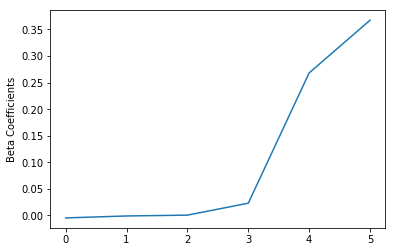

In [245]:
#Beta coefficients
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

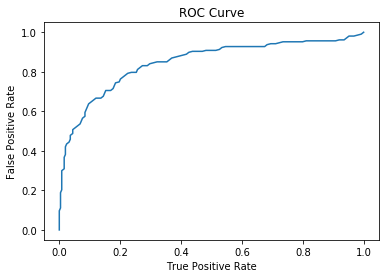

Training set areaUnderROC: 0.846390392488


In [246]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

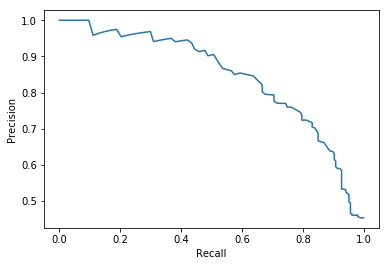

In [247]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [256]:
# Fazendo predições usando nossa base de teste.
# ['A2', 'A3', 'A8', 'A11', 'A14', 'A15', 'class']
predictions = lrModel.transform(test)
predictions.select('A2', 'A3', 'A8', 'A11', 'A14', 'A15', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+------+-----+----+-----+-----+-----+--------------------+----------+--------------------+
|   A2|    A3|   A8| A11|  A14|  A15|label|       rawPrediction|prediction|         probability|
+-----+------+-----+----+-----+-----+-----+--------------------+----------+--------------------+
|21.08|   5.0|  0.0| 0.0|  0.0|  0.0|  0.0|[1.33635588037100...|       0.0|[0.79189002853626...|
|48.75|26.335|  0.0| 0.0|  0.0|  0.0|  0.0|[0.97248293469536...|       0.0|[0.72561412261378...|
| 16.0| 0.165|  1.0| 2.0|320.0|  1.0|  0.0|[0.72851526956972...|       0.0|[0.67447937418588...|
| 16.0| 3.125|0.085| 1.0|  0.0|  6.0|  0.0|[0.96231534983313...|       0.0|[0.72358513716823...|
|16.25|   0.0| 0.25| 0.0| 60.0|  0.0|  0.0|[1.41996379692949...|       0.0|[0.80533274084638...|
|16.33|  2.75|0.665| 1.0| 80.0| 21.0|  0.0|[0.88506509685611...|       0.0|[0.70787073296978...|
|16.92| 0.335| 0.29| 0.0|200.0|  0.0|  0.0|[1.53929959911382...|       0.0|[0.82336288447538...|
|17.08|  3.29|0.335| 0.0|140.0

In [251]:
# Avaliando modelos
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

('Test Area Under ROC', 0.8141120117907157)


## Decision Tree Classifier

In [255]:
from pyspark.ml.classification import DecisionTreeClassifier
# ['A2', 'A3', 'A8', 'A11', 'A14', 'A15', 'class']
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('A2', 'A3', 'A8', 'A11', 'A14', 'A15', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+------+-----+----+-----+-----+-----+-------------+----------+--------------------+
|   A2|    A3|   A8| A11|  A14|  A15|label|rawPrediction|prediction|         probability|
+-----+------+-----+----+-----+-----+-----+-------------+----------+--------------------+
|21.08|   5.0|  0.0| 0.0|  0.0|  0.0|  0.0| [161.0,34.0]|       0.0|[0.82564102564102...|
|48.75|26.335|  0.0| 0.0|  0.0|  0.0|  0.0| [161.0,34.0]|       0.0|[0.82564102564102...|
| 16.0| 0.165|  1.0| 2.0|320.0|  1.0|  0.0| [161.0,34.0]|       0.0|[0.82564102564102...|
| 16.0| 3.125|0.085| 1.0|  0.0|  6.0|  0.0| [161.0,34.0]|       0.0|[0.82564102564102...|
|16.25|   0.0| 0.25| 0.0| 60.0|  0.0|  0.0| [161.0,34.0]|       0.0|[0.82564102564102...|
|16.33|  2.75|0.665| 1.0| 80.0| 21.0|  0.0| [161.0,34.0]|       0.0|[0.82564102564102...|
|16.92| 0.335| 0.29| 0.0|200.0|  0.0|  0.0| [161.0,34.0]|       0.0|[0.82564102564102...|
|17.08|  3.29|0.335| 0.0|140.0|  2.0|  0.0| [161.0,34.0]|       0.0|[0.82564102564102...|
|17.33|   

In [253]:
# Avaliando modelo
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.659036477524


## Random Forest Classifier

In [254]:
from pyspark.ml.classification import RandomForestClassifier
# ['A2', 'A3', 'A8', 'A11', 'A14', 'A15', 'class']
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('A2', 'A3', 'A8', 'A11', 'A14', 'A15', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+------+-----+----+-----+-----+-----+--------------------+----------+--------------------+
|   A2|    A3|   A8| A11|  A14|  A15|label|       rawPrediction|prediction|         probability|
+-----+------+-----+----+-----+-----+-----+--------------------+----------+--------------------+
|21.08|   5.0|  0.0| 0.0|  0.0|  0.0|  0.0|[16.6320873982832...|       0.0|[0.83160436991416...|
|48.75|26.335|  0.0| 0.0|  0.0|  0.0|  0.0|[16.5117698713092...|       0.0|[0.82558849356546...|
| 16.0| 0.165|  1.0| 2.0|320.0|  1.0|  0.0|[13.9225089050802...|       0.0|[0.69612544525401...|
| 16.0| 3.125|0.085| 1.0|  0.0|  6.0|  0.0|[17.6099009410417...|       0.0|[0.88049504705208...|
|16.25|   0.0| 0.25| 0.0| 60.0|  0.0|  0.0|[17.8272672681758...|       0.0|[0.89136336340879...|
|16.33|  2.75|0.665| 1.0| 80.0| 21.0|  0.0|[15.2777458163194...|       0.0|[0.76388729081597...|
|16.92| 0.335| 0.29| 0.0|200.0|  0.0|  0.0|[17.9574953166553...|       0.0|[0.89787476583276...|
|17.08|  3.29|0.335| 0.0|140.0

In [257]:
# Avaliando modelo
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.814112011791


## Gradient-Boosted Tree Classifier

In [259]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('A2', 'A3', 'A8', 'A11', 'A14', 'A15', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+------+-----+----+-----+-----+-----+--------------------+----------+--------------------+
|   A2|    A3|   A8| A11|  A14|  A15|label|       rawPrediction|prediction|         probability|
+-----+------+-----+----+-----+-----+-----+--------------------+----------+--------------------+
|21.08|   5.0|  0.0| 0.0|  0.0|  0.0|  0.0|[1.04442315481501...|       0.0|[0.88981436319902...|
|48.75|26.335|  0.0| 0.0|  0.0|  0.0|  0.0|[1.22649248019565...|       0.0|[0.92077946135336...|
| 16.0| 0.165|  1.0| 2.0|320.0|  1.0|  0.0|[0.97080019918231...|       0.0|[0.87452785869475...|
| 16.0| 3.125|0.085| 1.0|  0.0|  6.0|  0.0|[0.89575366664370...|       0.0|[0.85711198057398...|
|16.25|   0.0| 0.25| 0.0| 60.0|  0.0|  0.0|[0.91251024153792...|       0.0|[0.86116745538780...|
|16.33|  2.75|0.665| 1.0| 80.0| 21.0|  0.0|[0.27945542937092...|       0.0|[0.63620049657739...|
|16.92| 0.335| 0.29| 0.0|200.0|  0.0|  0.0|[1.03724522630746...|       0.0|[0.88839895009919...|
|17.08|  3.29|0.335| 0.0|140.0

In [260]:
# Avaliando modelo
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.799511790715


In [261]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [262]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.8319362564480468